In [ ]:
!nvidia-smi
!nvcc --version

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

import os
import torch

BASE_PATH = os.path.dirname(os.getcwd())

VISIBLE_GPUS = [0]


os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
print("CUDA GPUS NUMBER: ", torch.cuda.device_count())


In [ ]:
import torch
print(f'Device Name: {torch.cuda.get_device_name()}')
print(f'Device Available: {torch.cuda.is_available()}')
print(f'Device Count: {torch.cuda.device_count()}')

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

In [ ]:
try:
    from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler, StepWithFixedGammaParamScheduler
    from fvcore.common.checkpoint import Checkpointer
    from urllib.parse import parse_qs, urlparse
    from IPython.display import display, HTML
    from torch.utils.data import Subset
    import matplotlib.pyplot as plt
    import cv2, random, json
    import pandas as pd
    import numpy as np
    import itertools
    import datetime
    import logging
    import torch
    import pytz
    import os
    import detectron2
    import detectron2.utils.comm as comm
    import detectron2.data.transforms as T
    from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader, get_detection_dataset_dicts
    from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR, LRMultiplier, WarmupParamScheduler
    from detectron2.solver.build import build_lr_scheduler, build_optimizer, get_default_optimizer_params
    from detectron2.engine import launch, DefaultTrainer, DefaultPredictor, default_setup
    from detectron2.data.samplers import InferenceSampler, RandomSubsetTrainingSampler
    from detectron2.checkpoint.detection_checkpoint import DetectionCheckpointer
    from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetFromList
    from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask
    from detectron2.evaluation import COCOEvaluator, inference_on_dataset
    from detectron2.engine import HookBase, EvalHook, PeriodicWriter
    from detectron2.data.datasets import register_coco_instances
    from detectron2.utils.events import get_event_storage
    from detectron2.utils.logger import setup_logger
    from detectron2.data.common import MapDataset
    from detectron2.modeling import build_model
    from detectron2.config import get_cfg
    from detectron2.config import CfgNode
    from collections import defaultdict
    from detectron2 import model_zoo
    from enum import Enum
except Exception as e:
    print(f'Error importing detectron2 module: \n{e}')

In [ ]:
TRAIN_DATASET_IMG = "/dataset/train/images"
TEST_DATASET_IMG = "/dataset/test/images"
VAL_DATASET_IMG = "/dataset/val/images"

TRAIN_DATASET_JSON = "/dataset/coco_format/train_unified.json"
TEST_DATASET_JSON = "/dataset/coco_format/test_unified.json"
VAL_DATASET_JSON = "/dataset/coco_format/val_unified.json"

train_dataset_name = 'unified_train'
test_dataset_name = 'unified_test'
val_dataset_name = 'unified_val'

json_paths = {
    "Train": TRAIN_DATASET_JSON,
    "Validation": VAL_DATASET_JSON,
    "Test": TEST_DATASET_JSON
}


In [ ]:
def dataloader_check(json_test_path, test_images_root_path, n_samples=2, name='test_dataset'):

    import matplotlib as mpl
    mpl.rcParams['figure.facecolor'] = 'none'
    mpl.rcParams['axes.facecolor'] = 'none'

    DatasetCatalog.clear()
    MetadataCatalog.clear()
    register_coco_instances(name, {}, json_test_path, test_images_root_path)
    test_metadata = MetadataCatalog.get(name)
    test_dataset_dicts = DatasetCatalog.get(name)

    ncols = 3
    nrows = int(np.ceil(n_samples / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), constrained_layout=True)
    
    axs = axs.ravel()
    
    for i, d in enumerate(random.sample(test_dataset_dicts, n_samples)):
        img = cv2.imread(d["file_name"])
        print(img.shape)
        visualizer = Visualizer(img, metadata=test_metadata, scale=0.5)
        # visualizer = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        
        axs[i].imshow(vis.get_image()[:, :, ::-1])
        axs[i].axis('off')
        axs[i].set_title(f"Image: {i}", fontsize=10)
        # axs[i].set_title(f"Image: {d['file_name'].split('/')[-1]}", fontsize=10)
        axs[i].set_facecolor('none')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        axs[j].set_facecolor('none')
        
    # plt.tight_layout(pad=0.5)
    plt.show()
        
dataloader_check(TEST_DATASET_JSON, TEST_DATASET_IMG, n_samples=9, name='test_dataset')

### Trainer Class

In [ ]:
class ValidationLoss(HookBase):
    def __init__(self, cfg, period=20, max_samples=None):
        super().__init__()
        self.cfg = cfg.clone()
        self._period = period
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.TEST
        self.max_samples = max_samples
        mapper = DatasetMapper(self.cfg, is_train=True)
        dataloader = build_detection_train_loader(self.cfg, mapper=mapper)
        if self.max_samples:
            self._loader = iter(itertools.islice(dataloader, self.max_samples))
        else:
            self._loader = iter(dataloader)

    def after_step(self):
        if self.trainer.iter < self._period:
            return
        try:
            data = next(self._loader)
        except StopIteration:
            self._loader = iter(itertools.islice(
                build_detection_train_loader(self.cfg, mapper=DatasetMapper(self.cfg, is_train=True)),
                self.max_samples
            ))
            data = next(self._loader)
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            with torch.no_grad():
                loss_dict = self.trainer.model(data)
                losses = sum(loss_dict.values())
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                assert torch.isfinite(losses).all(), loss_dict
                loss_dict_reduced = {"validation_" + k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                if comm.is_main_process():
                    self.trainer.storage.put_scalars(validation_total_loss=losses_reduced, **loss_dict_reduced)



class DeepUFSCTrainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_val")
            os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name=dataset_name, use_fast_impl=False, output_dir=output_folder)


    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        name = cfg.SOLVER.LR_SCHEDULER_NAME
        if name == "WarmupMultiStepLR":
            steps = [x for x in cfg.SOLVER.STEPS if x <= cfg.SOLVER.MAX_ITER]
            if len(steps) != len(cfg.SOLVER.STEPS):
                logger = logging.getLogger(__name__)
                logger.warning("SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.")
            sched = MultiStepParamScheduler(
              values=[cfg.SOLVER.GAMMA**k for k in range(len(steps) + 1)],
              milestones=steps,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "WarmupCosineLR":
            end_value = cfg.SOLVER.BASE_LR_END / cfg.SOLVER.BASE_LR
            assert end_value >= 0.0 and end_value <= 1.0, end_value
            sched = CosineParamScheduler(1, end_value)
        elif name == "WarmupStepWithFixedGammaLR":
            sched = StepWithFixedGammaParamScheduler(
              base_value=1.0,
              gamma=cfg.SOLVER.GAMMA,
              num_decays=cfg.SOLVER.NUM_DECAYS,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "OneCycleLR":
            return torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=cfg.ONECYCLE.LIMIT,
                base_momentum=cfg.ONECYCLE.MIN_MOMENTUM,
                max_momentum=cfg.ONECYCLE.MAX_MOMENTUM,
                total_steps=cfg.SOLVER.MAX_ITER,
                three_phase=cfg.ONECYCLE.THREE_PHASE
            )
        else:
            raise ValueError("Unknown LR scheduler: {}".format(name))

        sched = WarmupParamScheduler(
          sched,
          cfg.SOLVER.WARMUP_FACTOR,
          min(cfg.SOLVER.WARMUP_ITERS / cfg.SOLVER.MAX_ITER, 1.0),
          cfg.SOLVER.WARMUP_METHOD,
          cfg.SOLVER.RESCALE_INTERVAL,
        )
        return LRMultiplier(optimizer, multiplier=sched, max_iter=cfg.SOLVER.MAX_ITER)

### Training config

In [ ]:
MODEL_CONFIG_NAME = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"

LR_METHODS = Enum("LR_METHODS", "COSINE FIXED STEP ONECYCLE")

NUM_EPOCH = 100
SAVE_EPOCH = 10
BSIZE = 80
NUM_WORKERS = 2
LEARNING_RATE = 0.001
WARMUP_ITERS = 100
EVAL_PERIOD = 20
MAX_EVAL_SAMPLES = 100
NMS_THRESH = 0.7
LR_MOMENTUM= 0.9
LR_STEPS_DECAY = [0.6, 0.8]
LR_STEP_RATE = 0.01
OC_LIMIT = 0.01
OC_MIN_MOMENTUM = 0.85
OC_MAX_MOMENTUM = 0.95
OC_THREE_PHASE = False

LR_METHOD = LR_METHODS.ONECYCLE


def count_categories(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    if 'categories' in data and isinstance(data['categories'], list):
        return len(data['categories'])
    else:
        return 0

NUM_CATEGORIES = count_categories(TRAIN_DATASET_JSON)
print(f'Dataset categories: {NUM_CATEGORIES}')

### Set Config and Train

In [ ]:
def set_config(
    model_config_name,
    output_model_path,
    train_dataset_name,
    train_images_root_path,
    val_dataset_name,
    val_images_root_path,
    lr,
    img_bs,
    bs,
    num_epoch,
    warmup_iters,
    eval_period,
    max_eval_samples,
    full_model_config_path = None,
    ):


    cfg = get_cfg()
    if full_model_config_path:
        cfg.merge_from_file(full_model_config_path)
    else:
        current_run = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
        dirname = "{dia}-{mes}-{ano}_{hora}_{minuto}_{segundo}".format(
            dia=current_run.day,
            mes=current_run.month,
            ano=current_run.year, 
            hora=current_run.hour,
            minuto=current_run.minute,
            segundo=current_run.second,
        )
        outdir = os.path.join(output_model_path, dirname)
        
        
        cfg.OUTPUT_DIR = outdir
        cfg.merge_from_file(model_zoo.get_config_file(model_config_name))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config_name)
        
        DatasetCatalog.clear()
        MetadataCatalog.clear()
        register_coco_instances(train_dataset_name, {}, TRAIN_DATASET_JSON, train_images_root_path)
        register_coco_instances(val_dataset_name, {}, VAL_DATASET_JSON, val_images_root_path)
        cfg.DATASETS.TRAIN = (train_dataset_name,)
        cfg.DATASETS.TEST = (val_dataset_name,)
        cfg.DATALOADER.NUM_WORKERS = NUM_WORKERS
        cfg.SOLVER.BASE_LR = lr
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = img_bs
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CATEGORIES
        cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = NUM_CATEGORIES
        cfg.SOLVER.IMS_PER_BATCH = bs #
        cfg.MODEL.RPN.NMS_THRESH = NMS_THRESH
        cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [NMS_THRESH]
        nr_img = len(DatasetCatalog.get(train_dataset_name))
        print(f'Images on Training set: {nr_img}')
        iter_per_epoch = nr_img / cfg.SOLVER.IMS_PER_BATCH
        print(f'Iterations per batch: {iter_per_epoch}')
        max_iter = int(num_epoch * iter_per_epoch)
        print(f'Total number of iterations: {max_iter}')
        cfg.SOLVER.MAX_ITER = max_iter
        cfg.SOLVER.WARMUP_ITERS = warmup_iters
        # cfg.TEST.EVAL_PERIOD = eval_period
        # cfg.TEST.EVAL_PERIOD = int(iter_per_epoch)
        if LR_METHOD == LR_METHODS.COSINE:
            cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
            cfg.SOLVER.MOMENTUM = LR_MOMENTUM
        elif LR_METHOD == LR_METHODS.STEP:
            cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
            cfg.SOLVER.GAMMA = LR_STEP_RATE
            cfg.SOLVER.STEPS = tuple( [int(cfg.SOLVER.MAX_ITER*LR_STEPS_DECAY[i]) for i in range(len(LR_STEPS_DECAY))])
        elif LR_METHOD == LR_METHODS.FIXED:
            cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
            cfg.SOLVER.STEPS = []
        elif LR_METHOD == LR_METHODS.ONECYCLE:
            cfg.ONECYCLE = CfgNode({
                "LIMIT": OC_LIMIT,
                "MAX_MOMENTUM": OC_MAX_MOMENTUM,
                "MIN_MOMENTUM": OC_MIN_MOMENTUM,
                "THREE_PHASE": OC_THREE_PHASE,
            })
            cfg.SOLVER.LR_SCHEDULER_NAME = "OneCycleLR"
            cfg.ONECYCLE.LIMIT = OC_LIMIT
            cfg.ONECYCLE.MIN_MOMENTUM = OC_MIN_MOMENTUM
            cfg.ONECYCLE.MAX_MOMENTUM = OC_MAX_MOMENTUM
            cfg.ONECYCLE.THREE_PHASE = OC_THREE_PHASE
            cfg.SOLVER.WARMUP_ITERS = warmup_iters
            cfg.SOLVER.STEPS = []
        else:
            raise ValueError(f"Unsupported LR_METHOD: {LR_METHOD}. Please check the configuration.")



        EPOCH_RATIO = NUM_EPOCH / SAVE_EPOCH
        cfg.SOLVER.CHECKPOINT_PERIOD = int(cfg.SOLVER.MAX_ITER/EPOCH_RATIO)

        os.makedirs(outdir, exist_ok=True)
        default_setup(cfg, '')
        out_config_path = outdir + '/' + MODEL_CONFIG_NAME.split('/')[-1]
        setup_logger(output=cfg.OUTPUT_DIR, distributed_rank=comm.get_rank(), name=model_config_name)
    
        with open(out_config_path,'w') as f:
            f.write(cfg.dump())

        
        ufsc_trainer = DeepUFSCTrainer(cfg)
        ufsc_trainer.register_hooks([ValidationLoss(cfg, eval_period, max_eval_samples)])
        pw_hook = [hook for hook in ufsc_trainer._hooks if isinstance(hook, PeriodicWriter)]
        all_hooks = [hook for hook in ufsc_trainer._hooks if not isinstance(hook, PeriodicWriter)]
        ufsc_trainer._hooks = all_hooks + pw_hook

        

        for hook in ufsc_trainer._hooks:
            print(type(hook))
            

    return ufsc_trainer

ufsc_trainer = set_config(
    model_config_name = MODEL_CONFIG_NAME,
    output_model_path = '/model_weights/mask_rcnn',
    train_dataset_name = 'unified_train',
    train_images_root_path = TRAIN_DATASET_IMG,
    val_dataset_name = 'unified_val',
    val_images_root_path = VAL_DATASET_IMG,
    lr = 0.0001,
    img_bs = 512,
    bs = BSIZE,
    num_epoch = 100,
    eval_period = EVAL_PERIOD,
    max_eval_samples = MAX_EVAL_SAMPLES,
    warmup_iters = 500,
    )


ufsc_trainer.resume_or_load(resume=False)
ufsc_trainer.train()

### Train results

Chaves disponíveis no arquivo de métricas:
dict_keys(['rpn/num_pos_anchors', 'mask_rcnn/false_negative', 'validation_loss_cls', 'rank_data_time', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'mask_rcnn/false_positive', 'lr', 'rpn/num_neg_anchors', 'time', 'total_loss', 'validation_loss_rpn_loc', 'loss_cls', 'iteration', 'mask_rcnn/accuracy', 'loss_rpn_loc', 'data_time', 'validation_loss_mask', 'eta_seconds', 'loss_rpn_cls', 'fast_rcnn/false_negative', 'validation_loss_rpn_cls', 'validation_total_loss', 'fast_rcnn/cls_accuracy', 'validation_loss_box_reg', 'loss_mask'])


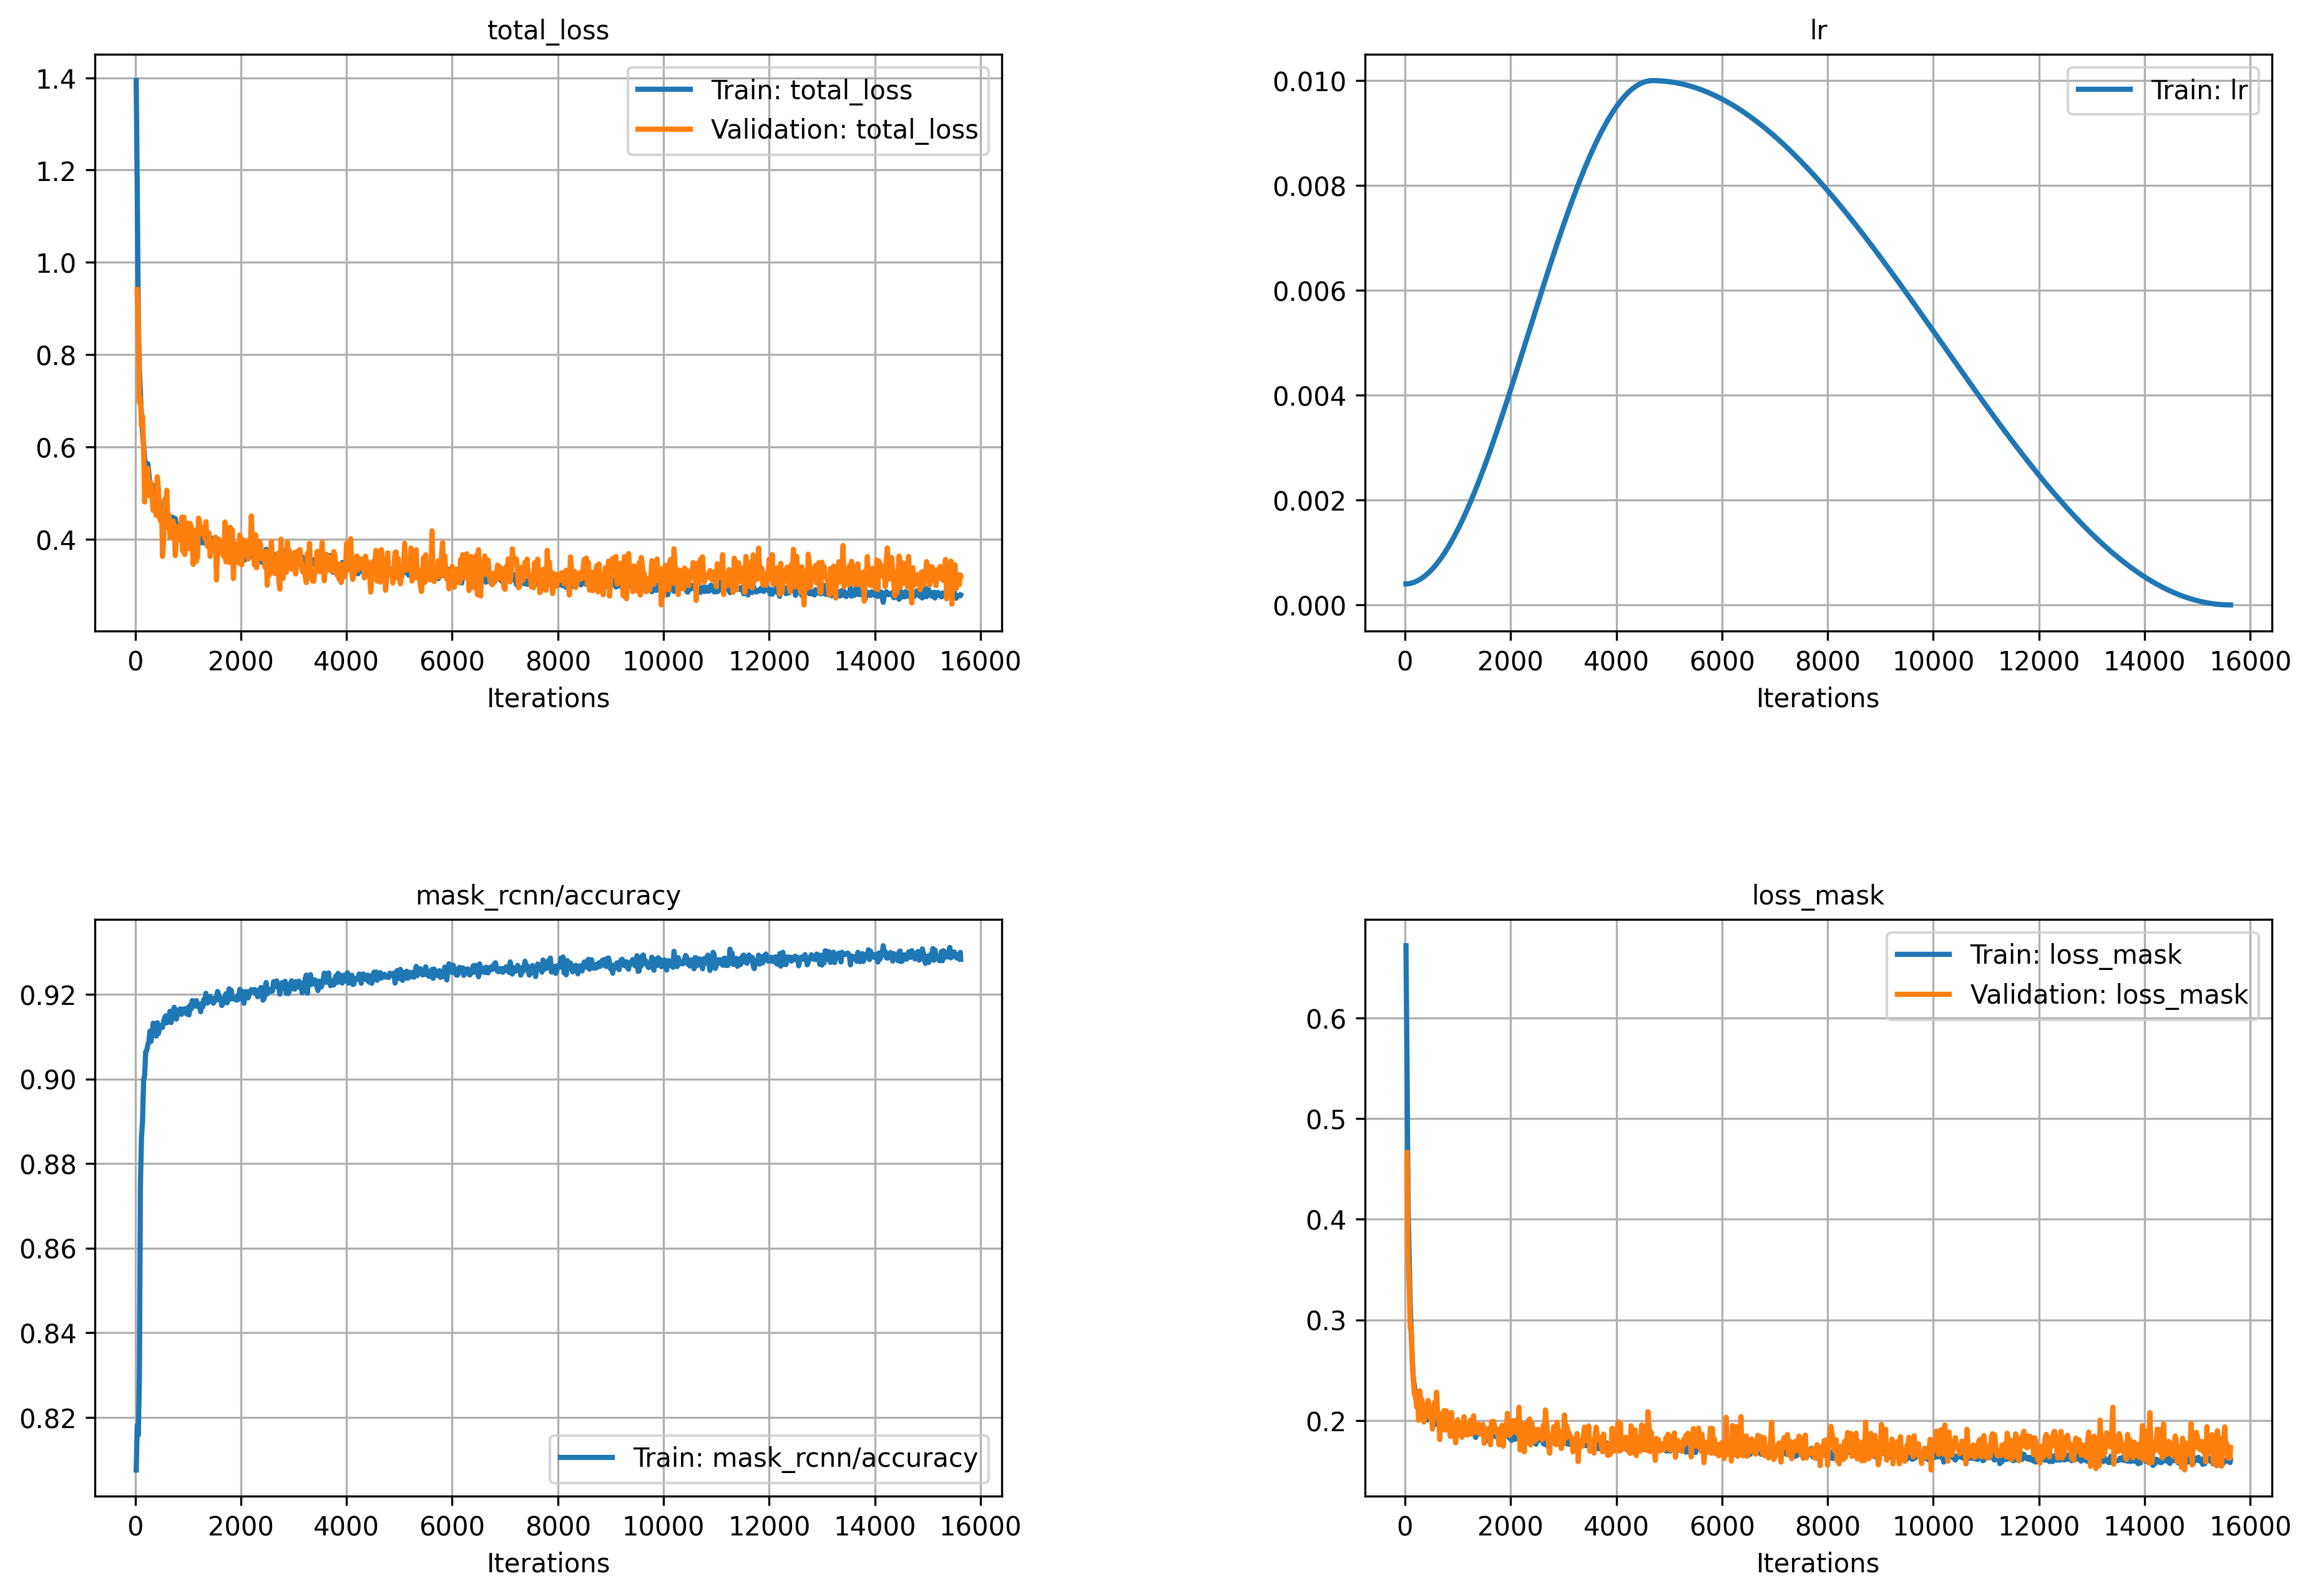

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def process_metrics(metric_file):
    torch.cuda.empty_cache()
    metrics = []
    with open(metric_file, 'r') as infile:
        for line in infile:
            metrics.append(json.loads(line))

    APmetrics = metrics[-1] if "bbox/AP" in metrics[-1].keys() else None
    if APmetrics is not None:
        metrics.pop(-1)
        APmetrics.pop('iteration', None)

    all_keys = set()
    for m in metrics:
        all_keys.update(m.keys())

    mt = dict()
    for k in all_keys:
        _temp = [m.get(k, None) for m in metrics]
        mt[k] = _temp

    return mt, APmetrics

def plot_training_and_validation(mt, keys, validation_prefix="validation_", figsize=(15, 10), rem_background=True):
    if rem_background:
        import matplotlib as mpl
        mpl.rcParams['figure.facecolor'] = 'none'
        mpl.rcParams['axes.facecolor'] = 'none'
    
    
    fig = plt.figure(figsize=figsize, dpi=300)
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    
    num_plots = len(keys)
    rows = 2
    cols = (num_plots // rows) + (1 if num_plots % rows != 0 else 0)
    
    for i, k in enumerate(keys):
        if k in mt and 'iteration' in mt:
            plt.subplot(rows, cols, i + 1)
            
            plt.plot(mt["iteration"], mt[k], label=f"Train: {k}", linewidth=2.0)
            
            val_key = validation_prefix + k
            if val_key in mt:
                plt.plot(mt["iteration"], mt[val_key], label=f"Validation: {k}", linestyle='-', linewidth=2.0)
            
            plt.xlabel("Iterations", fontsize=10)
            plt.title(k, fontsize=10)
            plt.legend()
            plt.grid()
    
    plt.show()


train_metrics_file = '/dataset/metrics.json'
mt, APmetrics = process_metrics(train_metrics_file)
keys = ["total_loss", "lr", "mask_rcnn/accuracy", "loss_mask"]
plot_training_and_validation(mt, keys)

In [11]:
from detectron2.config import CfgNode
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg, CfgNode
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask, random_color

from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
)
import torch
import os
import cv2
import random
import warnings
import math
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader

In [ ]:
def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def inference_on_test_set(test_dataset_name, test_dataset_json, test_dataset_img, weights_path, config_file, output_dir, output_folder_name):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances(test_dataset_name, {}, test_dataset_json, test_dataset_img)

    cfg_test = get_cfg()
    add_onecycle_config(cfg_test)
    cfg_test.merge_from_file(config_file)
    cfg_test.MODEL.WEIGHTS = weights_path
    cfg_test.OUTPUT_DIR = output_dir
    os.makedirs(cfg_test.OUTPUT_DIR, exist_ok=True)

    cfg_test.DATASETS.TEST = (test_dataset_name,)

    with torch.no_grad():
    
        predictor = DefaultPredictor(cfg_test)
    
        out_folder = os.path.join(cfg_test.OUTPUT_DIR, output_folder_name)
        os.makedirs(out_folder, exist_ok=True)
    
        evaluator = COCOEvaluator(test_dataset_name, output_dir=out_folder)
        test_loader = build_detection_test_loader(cfg_test, test_dataset_name)
    
        results = inference_on_dataset(predictor.model, test_loader, evaluator)
    
    return results
    

OUTDIR = '/model_weights/mask_rcnn/'

val_results = inference_on_test_set(
    test_dataset_name=val_dataset_name,
    test_dataset_json=VAL_DATASET_JSON,
    test_dataset_img=VAL_DATASET_IMG,
    weights_path=os.path.join(OUTDIR, 'best.pth'),
    config_file=os.path.join(OUTDIR, 'mask_rcnn_R_50_FPN_1x.yaml'),
    output_dir=OUTDIR,
    output_folder_name = 'val'
)


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.

In [ ]:
from tabulate import tabulate
def evaluation_results_to_table_compact(results):

    categories = set(
        category for metrics in results.values() for category in metrics.keys()
    )
    categories = sorted(categories)

    table_data = []
    for category in categories:
        row = [category]
        for metric_type in results.keys():
            value = results[metric_type].get(category, "N/A")
            row.append(value)
        table_data.append(row)

    headers = ["Category"] + list(results.keys())
    html_table = tabulate(table_data, headers=headers, tablefmt="html")

    datatables_script = """
    <link rel="stylesheet" href="https://cdn.datatables.net/1.13.4/css/jquery.dataTables.min.css">
    <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
    <script src="https://cdn.datatables.net/1.13.4/js/jquery.dataTables.min.js"></script>
    <script>
        $(document).ready(function() {
            $('table').DataTable({
                "paging": true,
                "searching": true,
                "ordering": true,
                "info": true,
                "autoWidth": false
            });
        });
    </script>
    <style>
        table.dataTable thead th {
            background-color: #008080;
            color: white;
        }
        div.dataTables_wrapper {
            margin: 20px 0;
        }
    </style>
    """

    styled_html = f"""
    <div style="overflow-x: auto; width:100%">
        {html_table}
    </div>
    {datatables_script}
    """
    display(HTML(styled_html))


evaluation_results_to_table_compact(val_results)

Category,bbox,segm
AP,31.9542,31.9167
AP-agnor_Cluster,0.789947,0.801658
AP-agnor_Leukocyte_Nucleus,29.2323,30.1314
AP-agnor_Nucleus,63.3796,64.8566
AP-agnor_Nucleus_out_of_focus,51.8212,53.4717
AP-agnor_Overlapped_Nuclei,nan,nan
AP-agnor_Satellite,0.107261,0.107261
AP-agnor_non_viable_nucleus,7.3961,7.51494
AP-feulgen_alterada,47.7467,48.9115
AP-feulgen_intermediaria,74.25,75.0265


###  Inference on test set

In [ ]:
def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def inference_on_test_set(test_dataset_name, test_dataset_json, test_dataset_img, weights_path, config_file, output_dir, output_folder_name):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances(test_dataset_name, {}, test_dataset_json, test_dataset_img)

    cfg_test = get_cfg()
    add_onecycle_config(cfg_test)
    cfg_test.merge_from_file(config_file)
    cfg_test.MODEL.WEIGHTS = weights_path
    cfg_test.OUTPUT_DIR = output_dir
    os.makedirs(cfg_test.OUTPUT_DIR, exist_ok=True)

    cfg_test.DATASETS.TEST = (test_dataset_name,)

    with torch.no_grad():
    
        predictor = DefaultPredictor(cfg_test)
    
        out_folder = os.path.join(cfg_test.OUTPUT_DIR, output_folder_name)
        os.makedirs(out_folder, exist_ok=True)
    
        evaluator = COCOEvaluator(test_dataset_name, output_dir=out_folder)
        test_loader = build_detection_test_loader(cfg_test, test_dataset_name)
    
        results = inference_on_dataset(predictor.model, test_loader, evaluator)
    
    return results



OUTDIR = '/path/to/output/directory'


test_results = inference_on_test_set(
    test_dataset_name=test_dataset_name,
    test_dataset_json=TEST_DATASET_JSON,
    test_dataset_img=TEST_DATASET_IMG,
    weights_path=os.path.join(OUTDIR, 'best.pth'),
    config_file=os.path.join(OUTDIR, 'mask_rcnn_R_50_FPN_1x.yaml'),
    output_dir=OUTDIR,
    output_folder_name = 'test'
)


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.

In [19]:
from tabulate import tabulate
def evaluation_results_to_table_compact(results):
    if not isinstance(results, dict):
        print("Os resultados fornecidos não estão no formato esperado.")
        return

    categories = set(
        category for metrics in results.values() for category in metrics.keys()
    )
    categories = sorted(categories)

    table_data = []
    for category in categories:
        row = [category]
        for metric_type in results.keys():
            value = results[metric_type].get(category, "N/A")
            row.append(value)
        table_data.append(row)

    headers = ["Category"] + list(results.keys())
    html_table = tabulate(table_data, headers=headers, tablefmt="html")

    datatables_script = """
    <link rel="stylesheet" href="https://cdn.datatables.net/1.13.4/css/jquery.dataTables.min.css">
    <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
    <script src="https://cdn.datatables.net/1.13.4/js/jquery.dataTables.min.js"></script>
    <script>
        $(document).ready(function() {
            $('table').DataTable({
                "paging": true,
                "searching": true,
                "ordering": true,
                "info": true,
                "autoWidth": false
            });
        });
    </script>
    <style>
        table.dataTable thead th {
            background-color: #008080;
            color: white;
        }
        div.dataTables_wrapper {
            margin: 20px 0;
        }
    </style>
    """

    styled_html = f"""
    <div style="overflow-x: auto; width:100%">
        {html_table}
    </div>
    {datatables_script}
    """
    display(HTML(styled_html))


evaluation_results_to_table_compact(val_results)

Category,bbox,segm
AP,31.9542,31.9167
AP-agnor_Cluster,0.789947,0.801658
AP-agnor_Leukocyte_Nucleus,29.2323,30.1314
AP-agnor_Nucleus,63.3796,64.8566
AP-agnor_Nucleus_out_of_focus,51.8212,53.4717
AP-agnor_Overlapped_Nuclei,nan,nan
AP-agnor_Satellite,0.107261,0.107261
AP-agnor_non_viable_nucleus,7.3961,7.51494
AP-feulgen_alterada,47.7467,48.9115
AP-feulgen_intermediaria,74.25,75.0265


### Visualização de Resultados

Caso não funcione, verifique o DefaultPredictor

In [20]:
class UFSCVisualizer(Visualizer):
    def __init__(self, img_rgb, metadata=None, scale=1.0, instance_mode=ColorMode.IMAGE):
        super().__init__(img_rgb, metadata, scale, instance_mode)

    def draw_instance_predictions(self, predictions, alpha=0.5, plot_mask=True):
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
        labels = self.create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        masks = None
        if plot_mask and predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in classes
            ]
        else:
            colors = None

        self.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
        return self.output

    def create_text_labels(self, classes, scores, class_names, is_crowd=None):
        """
        Args:
            classes (list[int] or None):
            scores (list[float] or None):
            class_names (list[str] or None):
            is_crowd (list[bool] or None):
    
        Returns:
            list[str] or None
        """
        labels = None
        if classes is not None:
            if class_names is not None and len(class_names) > 0:
                labels = [class_names[i] for i in classes]
            else:
                labels = [str(i) for i in classes]
        if scores is not None:
            if labels is None:
                labels = ["{:.0f}%".format(s * 100) for s in scores]
            else:
                labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
        if labels is not None and is_crowd is not None:
            labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
        return labels


def get_config(config_path, weights_path):
    cfg = get_cfg()
    cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = weights_path
    return cfg


def plot_test_results(cfg, DefaultPredictor, dataset_name, num_samples=4, threshold=0.5, alpha=0.4, plot_mask=True):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    with torch.no_grad():
        predictor = DefaultPredictor(cfg)
        for det in random.sample(dataset_dicts, num_samples):
            img = cv2.imread(det["file_name"])
            outputs = predictor(img)
            v = UFSCVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(dataset_name), scale=1.75)
            out = v.draw_instance_predictions(
                outputs['instances'][outputs['instances'].scores > threshold].to("cpu"),
                alpha=alpha,
                plot_mask=plot_mask
            )
            plt.figure(figsize=(10, 20))
            plt.imshow(out.get_image())
            # plt.imshow(out.get_image()[:, :, ::-1])
            plt.axis('off')
            plt.show()

In [ ]:
config_path = os.path.join(OUTDIR, "mask_rcnn_R_101_FPN_3x.yaml")
weights_path = os.path.join(OUTDIR, "best.pth")
cfg_test = get_config(config_path, weights_path)

plot_test_results(
    cfg=cfg_test,
    DefaultPredictor=DefaultPredictor,
    dataset_name='instance_test',
    num_samples=4,
    threshold=0.75,
    alpha=0.1,
    plot_mask=True
)

In [ ]:
import pickle

class UFSCCheckPointer(DetectionCheckpointer):
    def _load_file(self, filename):
        if filename.endswith(".pkl"):
            with self.path_manager.open(filename, "rb") as f:
                data = pickle.load(f, encoding="latin1")
            if "model" in data and "__author__" in data:
                self.logger.info("Reading a file from '{}'".format(data["__author__"]))
                return data
            else:
                if "blobs" in data:
                    data = data["blobs"]
                data = {k: v for k, v in data.items() if not k.endswith("_momentum")}
                return {"model": data, "__author__": "Caffe2", "matching_heuristics": True}
        elif filename.endswith(".pyth"):
            with self.path_manager.open(filename, "rb") as f:
                data = torch.load(f, map_location="cpu")
            assert "model_state" in data, f"Cannot load .pyth file {filename}"
            model_state = {
                k: v for k, v in data["model_state"].items() if not k.endswith("num_batches_tracked")
            }
            return {"model": model_state, "__author__": "pycls", "matching_heuristics": True}

        loaded = self._torch_load(filename)
        if "model" not in loaded:
            loaded = {"model": loaded}

        assert self._parsed_url_during_load is not None, "`_load_file` must be called inside `load`"
        parsed_url = self._parsed_url_during_load
        queries = parse_qs(parsed_url.query)
        if queries.pop("matching_heuristics", "False") == ["True"]:
            loaded["matching_heuristics"] = True
        if len(queries) > 0:
            raise ValueError(
                f"Unsupported query remaining: {queries}, original filename: {parsed_url.geturl()}"
            )
        return loaded

    def _torch_load(self, f):
        self.logger.info(f"Loading checkpoint {f} with safe weights-only mode.")
        return torch.load(f, map_location="cpu", weights_only=True)


class UFSCPredictor(DefaultPredictor):
    def __init__(self, cfg):
        self.cfg = cfg.clone()
        self.model = build_model(self.cfg)
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = UFSCCheckPointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )
        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        with torch.no_grad():
            if self.input_format == "RGB":
                original_image = original_image#[:, :, ::-1]
                # original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions


def load_model_with_ufsc_checkpointer(cfg, model):
    logger = logging.getLogger(__name__)
    logger.info(f"Loading model weights from {cfg.MODEL.WEIGHTS}")
    checkpointer = UFSCCheckPointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

In [ ]:
def plot_test_results(cfg, dataset_name, num_samples=4, threshold=0.5, alpha=0.4, plot_mask=True):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    with torch.no_grad():
        predictor = UFSCPredictor(cfg)  # Substitui DefaultPredictor
        for det in random.sample(dataset_dicts, num_samples):
            img = cv2.imread(det["file_name"])
            outputs = predictor(img)
            v = UFSCVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(dataset_name), scale=1.75)
            out = v.draw_instance_predictions(
                outputs['instances'][outputs['instances'].scores > threshold].to("cpu"),
                alpha=alpha,
                plot_mask=plot_mask
            )
            plt.figure(figsize=(10, 20))
            plt.imshow(out.get_image())
            # plt.imshow(out.get_image()[:, :, ::-1])
            plt.axis('off')
            plt.show()


In [ ]:
config_path = os.path.join(OUTDIR, "mask_rcnn_R_101_FPN_3x.yaml")
weights_path = os.path.join(OUTDIR, "best.pth")
cfg_test = get_config(config_path, weights_path)


plot_test_results(
    cfg=cfg_test,
    dataset_name='instance_test',
    num_samples=4,
    threshold=0.75,
    alpha=0.1,
    plot_mask=True
)

In [ ]:
def plot_test_results_with_gt(cfg, DefaultPredictor, dataset_name, num_samples=4, threshold=0.5, alpha=0.4, plot_mask=True):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    with torch.no_grad():
        predictor = DefaultPredictor(cfg)
        for det in random.sample(dataset_dicts, num_samples):
            img = cv2.imread(det["file_name"])
            outputs = predictor(img)
            
            fig, axs = plt.subplots(1, 2, figsize=(20, 10))
            
            v_gt = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
            vis_gt = v_gt.draw_dataset_dict(det)
            axs[0].imshow(vis_gt.get_image()[:, :, ::-1])
            axs[0].axis('off')
            axs[0].set_title('Ground Truth')
            
            v_pred = UFSCVisualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
            instances = outputs['instances'].to("cpu")
            filtered_instances = instances[instances.scores > threshold]
            out = v_pred.draw_instance_predictions(
                filtered_instances,
                alpha=alpha,
                plot_mask=plot_mask
            )
            axs[1].imshow(out.get_image()[:, :, ::-1])
            axs[1].axis('off')
            axs[1].set_title('Prediction')
            
            plt.show()


config_path = os.path.join(OUTDIR, "mask_rcnn_R_101_FPN_3x.yaml")
weights_path = os.path.join(OUTDIR, "best.pth")
cfg_test = get_config(config_path, weights_path)


plot_test_results(
    cfg=cfg_test,
    dataset_name='instance_test',
    num_samples=4,
    threshold=0.75,
    alpha=0.1,
    plot_mask=True
)